In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
%matplotlib inline

In [2]:
ni = 9
nb = 9

In [3]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = 0.25
k = sp.exp(-((x_1-y_1)**2+(x_2-y_2)**2) / (2*length_scale**2))
A = lambda f: sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)
Abar = lambda f: sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)
B = lambda f: f
Bbar = lambda f: f
symbols = [[x_1, x_2], [y_1, y_2]]

# interior observations: sin(x)*sin(y)
x_interior, y_interior = np.mgrid[0.1:0.9:ni*1j, 0.1:0.9:ni*1j]
interior = np.c_[x_interior.ravel(), y_interior.ravel()]
exterior = np.r_[
    np.c_[np.linspace(0.1,0.9,nb), np.zeros(nb)], 
    np.c_[np.linspace(0.1,0.9,nb), np.ones(nb)],
    np.c_[np.zeros(nb), np.linspace(0.1,0.9,nb)],
    np.c_[np.ones(nb), np.linspace(0.1,0.9,nb)]
]

interior_obs = np.sin(2*np.pi*interior[:,0]) + np.sin(2*np.pi*interior[:,1])
exterior_obs = np.r_[
    np.zeros(nb*2),
    np.zeros(nb*2)
]

print interior.shape, interior_obs.shape
print exterior.shape, exterior_obs.shape
posterior = bayesian_pdes.collocate([A, B], [Abar, Bbar], k, symbols, [(interior, interior_obs), (exterior, exterior_obs)])

(81, 2) (81,)
(36, 2) (36,)


/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


<matplotlib.colorbar.Colorbar instance at 0x10bb93998>

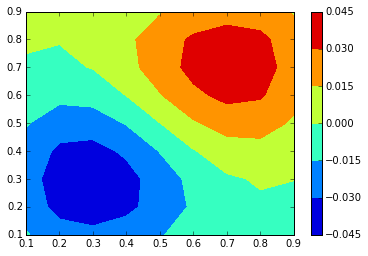

In [4]:
mean, cov = posterior(interior)
samp = np.random.multivariate_normal(mean, cov, 1)
plt.colorbar(plt.contourf(x_interior, y_interior, samp.reshape(x_interior.shape)))

In [25]:

def substitute(operators, dic):
    """
    Given an array of operator functionals, compose with the substitution functional specified by dic and return
    a new functional.
    """
    def __subs_op(o, dic):
        return lambda f: o(f).subs(dic)
    return [__subs_op(o, dic) for o in operators]


In [30]:
# set up the Allen-Cahn system
d = sp.Symbol('delta')
A_1 = lambda f: -d * (sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)) - 1./d * f
A_1_bar = lambda f: -d * (sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)) - 1./d * f
Identity = lambda f: f
B = Identity

ops = [A_1, Identity, B]
ops_bar = [A_1_bar, Identity, B]

# for now collocate on a basic grid (this is not efficient)
x_interior, y_interior = np.mgrid[0.1:0.9:ni*1j, 0.1:0.9:ni*1j]
collocate_interior = np.c_[x_interior.ravel(), y_interior.ravel()]
collocate_boundary = np.r_[
    np.c_[np.linspace(0.1,0.9,nb), np.zeros(nb)], 
    np.c_[np.linspace(0.1,0.9,nb), np.ones(nb)],
    np.c_[np.zeros(nb), np.linspace(0.1,0.9,nb)],
    np.c_[np.ones(nb), np.linspace(0.1,0.9,nb)]
]

# data points: these are where we observe the function
# for now we just match them
data = collocate_interior
# todo: observations of the data?!
values = np.random.uniform(data.shape[0])
true_obs = (data, values)

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(location.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = np.concatenate([
        np.ones(18),
        -np.ones(18)
    ])

z = np.random.uniform(size=interior.shape[0])
# given z, can construct the rhs
obs = [
    (interior, z),
    (interior, (-z)**1/3.),
    (exterior, boundary_obs)
]

In [39]:
def p_pn(true_obs, delta, z, sigma):
    """
    true_obs: Tuple of observation locations and observation values for the true solution u
    delta: The current value of the parameter delta
    z: The current value of the latent variable z
    sigma: Allowed observation error in the Gaussian likelihood.
    returns: The PN probability p(y | delta)
    """
    true_locations, y = true_obs
    
    obs = [
        (collocate_interior, z),
        (collocate_interior, (-z)**1/3.),
        (collocate_boundary, boundary_obs)
    ]
    
    ops_subs = substitute(ops, {d: delta})
    ops_bar_subs = substitute(ops_bar, {d: delta})
    
    posterior = bayesian_pdes.collocate(ops_subs, ops_bar_subs, k, symbols, obs)
    mu, Sigma = posterior(true_locations)
    
    error_mat = np.eye(mu.shape[0])*sigma
    Sigma_plus_error = Sigma + error_mat
    Sigma_plus_error_inv = np.linalg.inv(Sigma_plus_error)
    exponent = 0.5 * (y - mu).T.dot(Sigma_plus_error_inv).dot(y - mu)
    fractional = np.linalg.det(2*np.pi*Sigma_plus_error)
    
    return fractional**0.5 * np.exp(exponent)

In [40]:
p_pn(true_obs, 0.04, z, 5.)

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in exp


In [6]:
sp.init_printing()

In [7]:
from bayesian_pdes import collocation

In [8]:
LLBar = collocation.calc_LLbar(substitute(ops, {d: 0.04}), substitute(ops_bar, {d: 0.04}), k, symbols, obs)

In [9]:
U, s, Vh = np.linalg.svd(LLBar)

<matplotlib.colorbar.Colorbar instance at 0x10c040fc8>

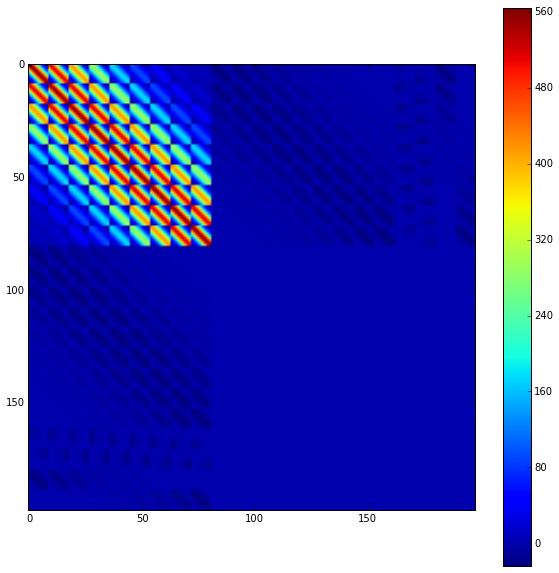

In [10]:
plt.figure(figsize=(10,10))
plt.colorbar(plt.imshow(LLBar, interpolation=None))

In [11]:
result = bayesian_pdes.collocate(substitute(ops, {d: 0.04}), substitute(ops_bar, {d: 0.04}), k, symbols, obs)

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


<matplotlib.contour.QuadContourSet instance at 0x10db0cab8>

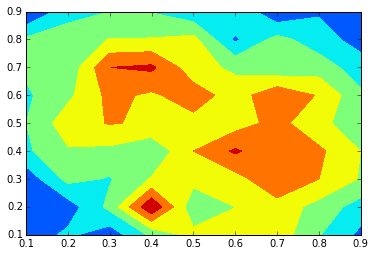

In [23]:
mu, Sigma = result(interior)
samp = np.random.multivariate_normal(mu, Sigma, 1)
plt.contourf(x_interior, y_interior, samp.reshape(x_interior.shape))